In [295]:
from foobah.gcode import GCODE
from foobah.utils import preview_svg
from foobah.methods import line_threshold
from foobah import constants
from foobah.constants import XMAX, XMIN, YMAX, YMIN

import PIL
import PIL.Image
import PIL.ImageFilter

import math
import numpy as np

import random
from random import uniform
from scipy.spatial import Voronoi, KDTree

from collections import defaultdict
from operator import itemgetter
from itertools import pairwise

from IPython.display import display

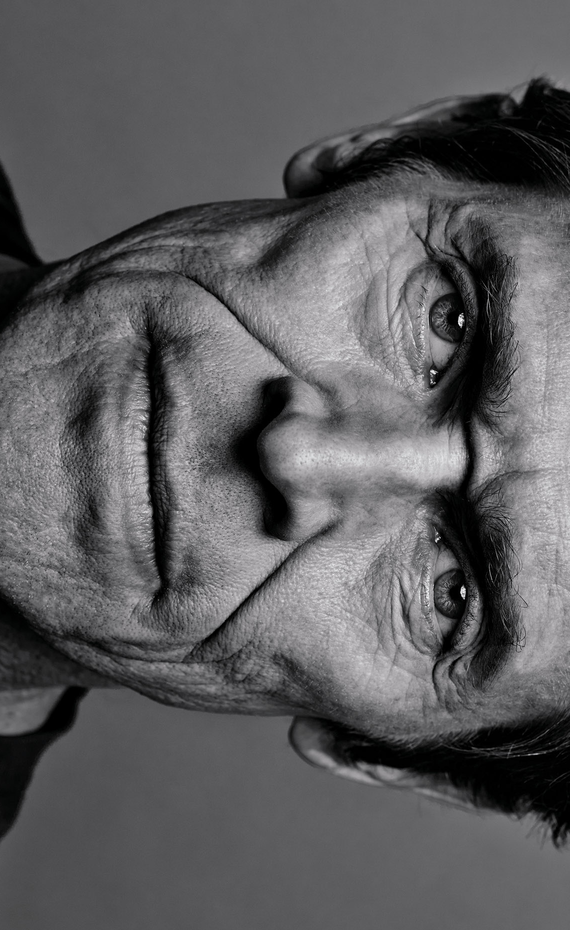

In [296]:
basename = "dafoe_voronoi"

scale = 2
# image_name = "images/moonface.png"
# image_name = "images/einstein.jpg"
# image_name = "images/david-bowie.jpg"
# image_name  = "images/scary_penguin.webp"
# image_name = "images/portrait_1.jpg"
image_name = "images/dafoe.jpg"

image = PIL.Image.open(image_name)

image = image.resize((int(image.width / scale), int(image.height / scale)), PIL.Image.ANTIALIAS)
# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE)
# image = image.filter(PIL.ImageFilter.SMOOTH_MORE)
# image = image.filter(PIL.ImageFilter.CONTOUR)
# image = image.filter(PIL.ImageFilter.DETAIL)
# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE)
# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE)
# image = image.filter(PIL.ImageFilter.SMOOTH_MORE)

image = image.rotate(-90, expand=True)

image = image.convert("RGB")

width = image.width
height = image.height

display(image)

In [297]:
point_cloud = []

pixel_step = 2

for x in range(0, image.width, pixel_step):
    for y in range(0, image.height, pixel_step):
        dx = uniform(-pixel_step / 2, pixel_step / 2)
        dy = uniform(-pixel_step / 2, pixel_step / 2)
        
        try:
            r, g, b = image.getpixel((x + dx, y + dy))
        except IndexError:
            continue
            
        intensity = ((255 - r) + (255 - g) + (255 - b)) / (255 * 3.0)
#         intensity = 1.0 - intensity
        
        if pow(intensity, 2.0) > uniform(0.2, 1):
            point_cloud.append((x + dx, y + dy))
            
print(len(point_cloud))

40182


In [298]:
min_dist = 3
print(len(point_cloud))

for _ in range(10):
    kd_tree = KDTree(point_cloud)
    close_points = kd_tree.query_pairs(min_dist)

    d = defaultdict(int)
    for p1, p2 in close_points:
        d[p1] += 1
        d[p2] += 1

    d_ = sorted(d.items(), key=itemgetter(1), reverse=True)

    point_cloud = [x for index, x in enumerate(point_cloud) if index not in d or uniform(0, 1) > 0.25]
    print(len(point_cloud))

40182
30969
24538
20133
17221
15248
14094
13350
12902
12600
12444


In [299]:
point_cloud = [x for x in point_cloud if uniform(0, 1) > 0.25]
print(len(point_cloud)) 

9357


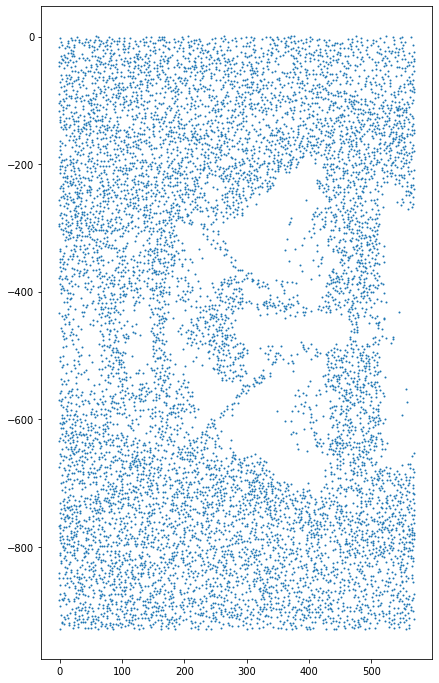

In [300]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 12))
plt.scatter(
    [x[0] for x in point_cloud], 
    [-x[1] for x in point_cloud],
    s=1,
)

In [301]:
def get_adjacent_edge(edges, vertex, eps=1e-4):
    for k, (v1, v2) in enumerate(edges):

        if dist(v1, vertex) < eps:
            return k, (v1, v2)
        
        if dist(v2, vertex) < eps:
            return k, (v2, v1)
        
    return None, None


def dist(a, b):
    if isinstance(a, (list, tuple)):
        a = np.array(a)
        
    if isinstance(b, (list, tuple)):
        b = np.array(b)
        
    return np.linalg.norm(a-b)

In [302]:
voronoi = Voronoi(point_cloud, furthest_site=False)
edges = []

for region in voronoi.regions:
    if -1 in region:
        continue
        
    polygon = list(voronoi.vertices[region])
    if len(polygon) == 0:
        continue
        
    polygon.append(polygon[0])
    zero = (0, 0)
    
    for p1, p2 in pairwise(polygon):
        p1 = tuple(p1)
        p2 = tuple(p2)
        if dist(0, p1) < dist(0, p2):
            edges.append((p1, p2))
        else:
            edges.append((p2, p1))


print(len(edges))
edges = list(set(edges))
print(len(edges))

55837
28010


In [303]:
def plot_line(gcode, edges):
    v1, v2 =edges.pop(0)
    
    gcode.pen_up()
    move_to(gcode, *v1)
    
    gcode.pen_down()
    
    move_to(gcode, *v2)
    
    while True:
        k, v = get_adjacent_edge(edges, v2)
        if not k:
            break
        
        edges.pop(k)
        _,  v2 = v
        
        move_to(gcode, *v2)
        
    
    gcode.pen_up()

In [304]:
def move_to(gcode, x, y, feedrate=1500):
    gcode.move_to(
        ((x) / image.width) * (XMAX - XMIN) + XMIN,
        ((y) / image.height) * (YMAX - YMIN) + YMIN,
        feedrate=feedrate,
    )
    
    
gcode = GCODE(basename, feedrate=1500)
gcode.pen_up()
gcode.move_to_mid_point()

# for region in voronoi.regions:
#     if -1 in region:
#         continue
        
#     polygon = voronoi.vertices[region]
#     if len(polygon) == 0:
#         continue
    
#     gcode.pen_up()
#     move_to(gcode, *polygon[0])
#     gcode.pen_down()
    
#     for p in polygon[1:]:
#         move_to(gcode, *p)
        
#     move_to(gcode, *polygon[0])
    
#     gcode.pen_up()

    
while len(edges) > 0:
    print(len(edges))
    plot_line(gcode, edges)
    
    
gcode.pen_up()
gcode.move_to_starting_position()
gcode.flush()

28010
28004
27994
27983
27976
27878
27829
27824
27807
27768
27727
27712
27684
27644
27630
27619
27606
27569
27544
27523
27510
27497
27465
27450
27414
27374
27329
27305
27244
27200
27180
27167
27153
27104
27054
27034
27015
26982
26968
26923
26906
26870
26837
26824
26815
26813
26739
26696
26647
26631
26612
26581
26559
26506
26499
26464
26399
26381
26345
26324
26308
26295
26242
26236
26229
26219
26214
26199
26156
26145
26142
26120
26105
26090
26082
26054
26041
26021
26001
25996
25979
25951
25933
25928
25868
25863
25839
25807
25790
25773
25745
25736
25717
25696
25680
25664
25659
25624
25610
25581
25529
25480
25455
25437
25406
25375
25348
25328
25299
25273
25262
25234
25222
25210
25190
25185
25177
25163
25151
25107
25076
25059
25054
25047
25030
24952
24940
24920
24917
24898
24887
24871
24862
24857
24835
24815
24791
24789
24781
24752
24749
24723
24713
24681
24669
24640
24635
24627
24615
24573
24564
24534
24524
24517
24493
24485
24469
24409
24396
24393
24381
24379
24365
24355
24349
24343
2433

14203
14199
14197
14187
14184
14175
14159
14155
14149
14146
14138
14135
14133
14127
14125
14122
14119
14117
14112
14111
14105
14104
14100
14098
14096
14094
14092
14081
14079
14077
14075
14073
14070
14065
14061
14055
14052
14041
14039
14027
14022
14020
14019
14016
14012
14006
13999
13998
13988
13979
13976
13966
13964
13962
13961
13958
13956
13954
13952
13950
13947
13942
13935
13933
13929
13923
13917
13914
13911
13905
13902
13900
13887
13878
13876
13872
13868
13862
13861
13858
13856
13854
13849
13846
13842
13839
13837
13831
13829
13826
13823
13814
13809
13807
13801
13787
13781
13778
13773
13770
13767
13759
13755
13753
13751
13747
13744
13742
13735
13728
13724
13719
13716
13709
13704
13696
13695
13693
13689
13684
13680
13676
13674
13671
13669
13665
13663
13661
13655
13648
13646
13643
13635
13633
13627
13623
13618
13616
13615
13611
13605
13603
13597
13592
13590
13588
13585
13581
13572
13562
13557
13549
13540
13538
13535
13531
13520
13516
13513
13512
13508
13497
13495
13491
13488
13485
1348

9897
9895
9893
9892
9891
9889
9887
9885
9880
9878
9875
9873
9871
9868
9866
9864
9861
9859
9856
9852
9851
9849
9848
9846
9841
9837
9835
9832
9831
9828
9825
9824
9820
9819
9817
9816
9811
9810
9808
9807
9806
9802
9801
9799
9797
9793
9791
9789
9788
9786
9782
9779
9778
9776
9773
9770
9767
9766
9762
9761
9760
9759
9757
9753
9749
9746
9740
9739
9737
9735
9734
9733
9732
9731
9729
9724
9723
9721
9719
9717
9715
9711
9710
9707
9704
9700
9699
9697
9696
9694
9691
9689
9688
9687
9686
9682
9681
9679
9678
9674
9673
9672
9670
9669
9668
9665
9660
9658
9653
9651
9648
9647
9646
9645
9643
9641
9639
9636
9634
9632
9631
9627
9625
9621
9619
9617
9616
9614
9613
9611
9609
9598
9597
9592
9590
9589
9588
9582
9581
9580
9579
9578
9576
9573
9569
9568
9566
9564
9563
9561
9560
9558
9557
9556
9555
9554
9553
9552
9551
9542
9541
9539
9537
9526
9524
9523
9522
9520
9518
9516
9514
9510
9508
9506
9499
9498
9497
9494
9492
9489
9488
9485
9484
9481
9480
9479
9477
9476
9475
9474
9472
9471
9470
9468
9467
9466
9462
9461
9459
9458


6855
6852
6850
6849
6848
6847
6845
6843
6842
6841
6840
6839
6838
6836
6835
6834
6833
6832
6831
6830
6829
6828
6826
6825
6823
6822
6821
6820
6819
6817
6815
6813
6812
6811
6810
6809
6808
6807
6805
6803
6802
6800
6799
6798
6797
6796
6795
6794
6793
6792
6791
6789
6788
6787
6785
6784
6783
6782
6781
6780
6778
6777
6776
6775
6774
6772
6771
6769
6768
6766
6764
6763
6762
6760
6759
6758
6756
6755
6754
6753
6751
6749
6748
6747
6746
6745
6744
6743
6742
6741
6739
6738
6736
6735
6734
6733
6729
6728
6726
6723
6722
6720
6719
6717
6715
6712
6711
6710
6708
6705
6698
6697
6695
6694
6692
6691
6690
6688
6687
6686
6685
6684
6682
6681
6680
6678
6677
6676
6674
6673
6672
6670
6667
6664
6663
6662
6660
6658
6657
6656
6655
6654
6653
6652
6651
6650
6647
6644
6642
6641
6638
6635
6633
6631
6630
6629
6625
6623
6621
6619
6618
6617
6616
6615
6613
6610
6609
6608
6605
6602
6599
6598
6597
6595
6594
6593
6592
6591
6590
6588
6586
6585
6582
6580
6578
6577
6576
6575
6574
6573
6572
6571
6568
6567
6566
6565
6564
6562
6561
6560


4503
4501
4500
4499
4498
4497
4496
4495
4494
4492
4489
4487
4486
4485
4484
4483
4482
4478
4477
4475
4474
4473
4472
4471
4469
4468
4467
4466
4465
4464
4463
4462
4461
4460
4459
4458
4457
4456
4453
4452
4451
4450
4449
4448
4446
4445
4444
4442
4440
4439
4438
4437
4436
4435
4433
4432
4431
4430
4428
4426
4425
4424
4422
4421
4420
4419
4418
4417
4415
4414
4413
4412
4411
4410
4408
4404
4400
4399
4397
4396
4395
4394
4393
4392
4391
4390
4389
4388
4387
4386
4384
4383
4382
4381
4379
4377
4374
4372
4371
4370
4368
4367
4366
4365
4363
4362
4360
4359
4358
4357
4355
4354
4353
4352
4351
4349
4347
4344
4343
4342
4341
4340
4339
4338
4337
4335
4334
4333
4332
4331
4330
4329
4328
4327
4326
4324
4322
4320
4319
4318
4317
4316
4315
4314
4311
4310
4309
4308
4307
4306
4305
4304
4303
4302
4301
4300
4298
4296
4294
4293
4290
4289
4288
4287
4285
4284
4282
4281
4279
4278
4277
4276
4275
4274
4273
4272
4271
4270
4269
4268
4267
4265
4264
4263
4262
4261
4260
4259
4258
4256
4255
4254
4252
4250
4249
4248
4246
4245
4244
4243


2536
2534
2533
2532
2531
2530
2529
2528
2527
2526
2525
2524
2523
2522
2521
2520
2519
2518
2517
2515
2512
2511
2510
2508
2507
2506
2505
2504
2503
2502
2501
2500
2499
2497
2496
2495
2494
2493
2491
2490
2489
2487
2486
2485
2484
2483
2482
2480
2479
2478
2476
2475
2474
2473
2472
2470
2469
2468
2467
2466
2465
2464
2463
2462
2461
2460
2459
2458
2457
2456
2455
2454
2453
2451
2450
2449
2448
2447
2446
2445
2444
2443
2442
2441
2440
2439
2438
2437
2436
2434
2432
2431
2430
2429
2428
2427
2425
2424
2423
2422
2421
2420
2419
2418
2417
2416
2415
2414
2413
2412
2411
2410
2409
2408
2407
2406
2405
2403
2402
2401
2400
2399
2398
2397
2396
2395
2394
2393
2392
2391
2390
2389
2388
2387
2386
2384
2383
2382
2381
2380
2379
2378
2377
2376
2375
2374
2372
2371
2370
2369
2368
2367
2366
2365
2364
2362
2361
2360
2359
2358
2356
2355
2354
2352
2351
2350
2349
2348
2347
2346
2345
2344
2343
2342
2341
2340
2339
2337
2336
2335
2333
2332
2331
2329
2328
2327
2326
2325
2324
2323
2322
2321
2320
2318
2317
2316
2315
2314
2313
2312


707
706
705
704
703
702
701
700
699
698
697
696
695
694
693
692
691
690
689
688
687
686
685
684
683
682
681
680
679
678
677
676
675
674
673
672
671
670
669
668
667
666
665
664
663
662
661
660
659
658
657
656
655
654
653
652
651
650
649
648
647
646
645
644
642
641
640
639
638
637
636
635
634
633
632
631
630
628
627
626
625
624
623
622
621
620
619
618
617
616
615
614
613
612
610
608
607
606
605
604
603
602
601
600
599
598
597
596
595
594
593
592
591
590
589
588
587
585
584
583
582
581
580
579
578
577
576
575
574
573
572
571
570
569
568
567
566
565
564
563
562
561
560
559
558
557
556
555
554
553
552
551
550
549
548
547
546
545
544
542
541
540
539
538
537
536
535
534
533
532
531
530
529
528
527
526
525
524
523
522
521
520
519
518
517
516
515
514
513
512
511
510
509
508
507
506
505
504
503
501
500
499
498
497
496
494
493
492
491
490
489
488
487
486
485
484
482
481
480
479
478
477
476
475
474
473
472
471
470
469
468
467
466
465
464
463
461
460
459
458
457
456
455
454
453
452
451
450
449
447


In [ ]:
preview_svg(basename)